In [1]:
import sionna
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

tf.random.set_seed(1) # Set global random seed for reproducibility

2024-03-14 16:42:58.259433: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-14 16:42:58.336856: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-14 16:42:59.659820: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from sionna.channel import subcarrier_frequencies, cir_to_ofdm_channel
# Import Sionna RT components
from mysionna.rt import load_scene, Transmitter, Receiver, PlanarArray
from mysionna.rt.scattering_pattern import *

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
# Load integrated scene
# scene = load_scene("./Single Box/Single Box.xml") # Try also sionna.rt.scene.etoile
scene = load_scene("./scenes/Street/street.xml") # Try also sionna.rt.scene.etoile

2024-03-14 16:43:06.492050: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20538 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:b1:00.0, compute capability: 8.9


In [4]:
p1 = LambertianPattern()
p2 = DirectivePattern(20)
if scene.get("itu_plywood") is not None:
    scene.get("itu_plywood").scattering_coefficient = 0.3
    scene.get("itu_plywood").scattering_pattern = p1
if scene.get("itu_concrete") is not None:
    scene.get("itu_concrete").scattering_coefficient = 0.5
    scene.get("itu_concrete").scattering_pattern = p1
if scene.get("itu_glass") is not None:
    scene.get("itu_glass").scattering_coefficient = 0.25
    scene.get("itu_glass").scattering_pattern = p2
if scene.get("itu_medium_dry_ground") is not None:
    scene.get("itu_medium_dry_ground").scattering_coefficient = 0.8
    scene.get("itu_medium_dry_ground").scattering_pattern = p1
if scene.get("itu_metal") is not None:
    scene.get("itu_metal").scattering_coefficient = 0.1
    scene.get("itu_metal").scattering_pattern = p2

In [5]:
#################配置发端天线阵列#################
scene.tx_array = PlanarArray(num_rows=16,
                             num_cols=16,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="dipole",
                             polarization="V")

#################配置收端天线阵列#################
scene.rx_array = PlanarArray(num_rows=16,
                             num_cols=16,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="dipole",
                             polarization="V")

################创建发射机#########################
tx = Transmitter(name="tx",
                 position=[0,0,2.95])
################ 将发射机加入到场景中##############
scene.add(tx)
#################创建接收机########################
rx = Receiver(name="rx",
              position=[0,0,2.95])
################ 将接收机加入到场景中##############
scene.add(rx)
tx.look_at([0,0,0])
rx.look_at([0,0,0])

In [7]:
scene.frequency = 6e9 # in Hz; implicitly updates RadioMaterials
scene.synthetic_array = True # If set to False, ray tracing will be done per antenna element (slower for large arrays)

In [8]:
paths = scene.compute_paths(max_depth=3,num_samples=1e6,los=True,reflection=True,scattering=True,diffraction=True)
paths.normalize_delays = False

In [82]:
scene.target_names = ["door"]
scene.target_velocities = [(5.,5.,0.)]
v,obj=scene.compute_target_velocities(paths, return_obj_names=True)
subcarrier_spacing = 15e3
num_time_steps = 14
paths.apply_doppler(sampling_frequency=subcarrier_spacing, num_time_steps=num_time_steps,target_velocities=v)

In [9]:
scene.preview(paths=paths,show_paths=True)

Renderer(camera=PerspectiveCamera(aspect=1.31, children=(DirectionalLight(intensity=0.25, position=(0.0, 0.0, …

In [9]:
a, tau = paths.cir()
print("Shape of tau: ", a.shape)

Shape of tau:  (1, 1, 256, 1, 256, 13, 1)


Text(0, 0.5, '$|a|$')

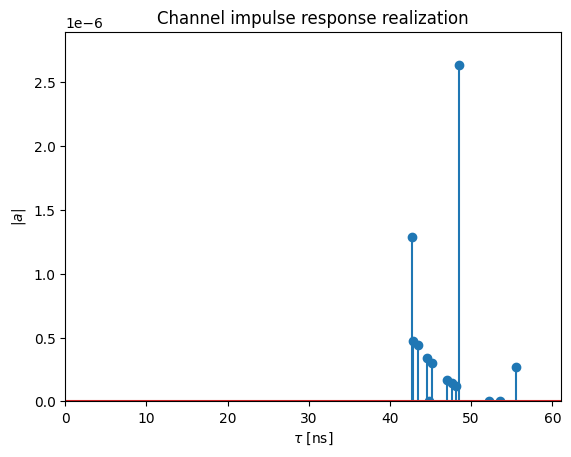

In [10]:
t = tau[0,0,0,:]/1e-9 # Scale to ns
a_abs = np.abs(a)[0,0,0,0,0,:,0]
t = t[a_abs!=0]
a_abs = a_abs[a_abs!=0]
a_max = np.max(a_abs)
# Add dummy entry at start/end for nicer figure
t = np.concatenate([(0.,), t, (np.max(t)*1.1,)])
a_abs = np.concatenate([(np.nan,), a_abs, (np.nan,)])

# And plot the CIR
plt.figure()
plt.title("Channel impulse response realization")

plt.stem(t, a_abs)
plt.xlim([0, np.max(t)])
plt.ylim([0, a_max*1.1])
plt.xlabel(r"$\tau$ [ns]")
plt.ylabel(r"$|a|$")


In [15]:
subcarrier_num = 64
subcarrier_spacing = 15e3
frequencies = subcarrier_frequencies(subcarrier_num, subcarrier_spacing)
h_freq = cir_to_ofdm_channel(frequencies, a, tau, normalize=True)
ebno_db = 20

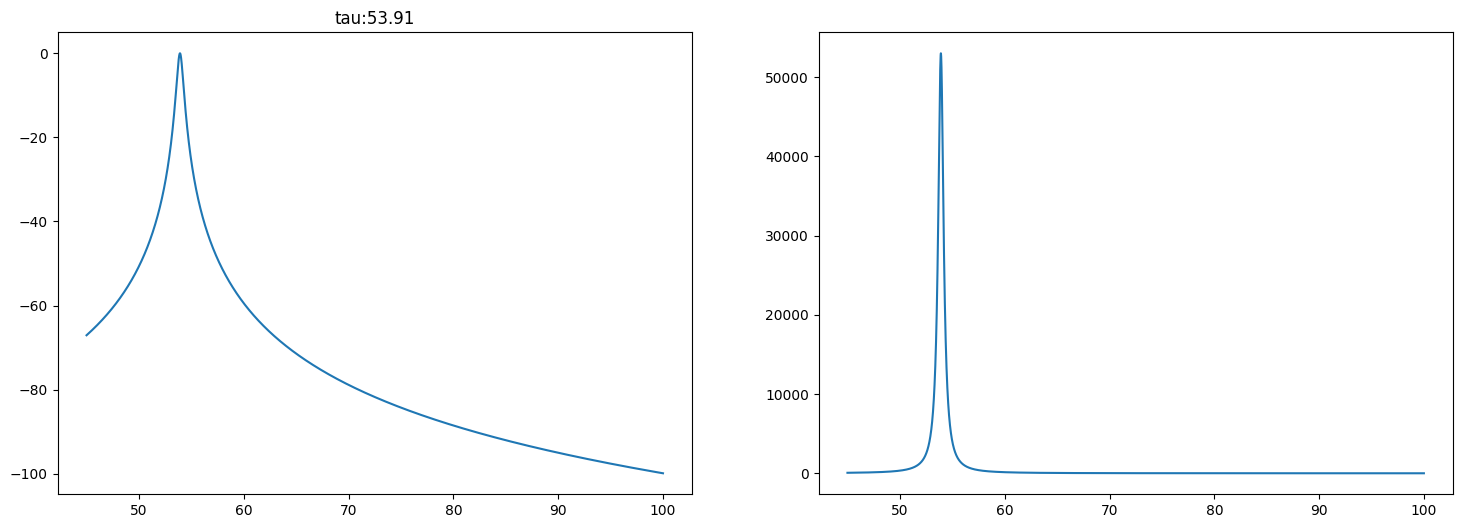

In [18]:
start = 45
end = 100
step = 0.01
y_i = h_freq[0,0,0,0,0,0,:]
y_i = tf.squeeze(y_i)
y_i = tf.expand_dims(y_i, axis=0)
y_i_H = tf.transpose(tf.math.conj(y_i))
y_conv = tf.matmul(y_i_H, y_i)
eig_vals, eig_vecs = tf.linalg.eigh(y_conv)
tau_range = np.arange(start,end, step)
frequencies_c = tf.cast(frequencies, dtype=tf.complex64)

P_tau_array = tf.TensorArray(dtype=tf.complex64, size=len(tau_range))
G_n = tf.cast(eig_vecs[:,:-1], dtype=tf.complex64)
G_n_H = tf.math.conj(tf.transpose(G_n))
for idx in range(len(tau_range)):
    a_m = tf.expand_dims(tf.math.exp(-1j * 2 * np.pi * frequencies_c * (tau_range[idx]/1e9)), axis=0)
    a_m_H = tf.math.conj(tf.transpose(a_m))
    P_tau_array = P_tau_array.write(idx, 1 / (a_m @ G_n @ G_n_H @ a_m_H))

P_tau = P_tau_array.stack()
# 计算谱函数
P_tau_real, P_tau_imag = tf.math.real(P_tau), tf.math.imag(P_tau)
P_abs = tf.math.sqrt(P_tau_real**2 + P_tau_imag**2)
P_norm = 10 * tf.math.log(P_abs / tf.reduce_max(P_abs), 10)
P_norm = tf.squeeze(P_norm)
max_idx = tf.argmax(P_norm)
# 绘制
# 调整画布大小
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.plot(tau_range, tf.squeeze(P_norm))
plt.title(f"tau:{(start + int(max_idx) * step)}")
plt.subplot(1, 2, 2)
plt.plot(tau_range, tf.squeeze(P_abs))

In [19]:
snr = ebno_db
bandwidth = subcarrier_num*subcarrier_spacing
H=a[0,0,0,0,0,:,0]
H=H[H!=0]
H_H = tf.math.conj(tf.transpose(H))
l = len(H)
B = tf.reshape(H_H, [l,1]) @ tf.reshape(H, [1,l])
B_abs = tf.abs(B)
B_inv = tf.linalg.pinv(B_abs)
B_diag = tf.linalg.diag_part(B_inv)
crb1 = tf.abs(tf.cast(B_diag,tf.complex128)) / tf.cast((8 * np.pi**2 * snr * scene.frequency **2),tf.float64)
crb1

<tf.Tensor: shape=(13,), dtype=float64, numpy=
array([1.39783943e-12, 3.34358194e-13, 1.44380281e-14, 2.80657524e-15,
       4.00779916e-15, 5.94062896e-15, 1.79875149e-14, 2.37151088e-14,
       3.92564085e-14, 4.47127746e-14, 8.14881018e-35, 0.00000000e+00,
       0.00000000e+00])>

In [99]:
#CRB 2
import math
alpha=paths.a[0,0,0,0,0,:,0]
tau=paths.tau[0,0,0,:]
tau=tau[alpha!=0]
alpha=alpha[alpha!=0]
tau_complex = tf.cast(tau, tf.complex64)
# e = tf.exp(1j*2*tf.cast(np.pi,tf.complex64)*tf.cast(scene.frequency,tf.complex64)*tau_complex)
# alpha = alpha * e
length = len(alpha)
tau_i = tf.repeat(tau,length)
tau_i = tf.reshape(tau_i, (length,length))
tau_j = tf.transpose(tau_i)
tau_i_mine_j = tau_i- tau_j
tau_i_mul_j = tau_i* tau_j
alpha_ij = tf.reshape(alpha, (length,1)) @ tf.reshape(alpha, (1,length))
one = tf.ones((length,length))
F_alpha= 2*snr*tf.math.abs(alpha_ij)/(tau_i_mul_j**2)
F_cos = (one+4*(np.pi**2)*(scene.frequency) * tau_i_mul_j)*tf.math.cos(2*np.pi*scene.frequency*tau_i_mine_j)
F_sin = 2*np.pi*scene.frequency*tau_i_mine_j*tf.math.sin(2*np.pi*scene.frequency*tau_i_mine_j)
F = F_alpha*(F_cos+F_sin)
crb_F = tf.linalg.pinv(F)
crb2 = tf.linalg.diag_part(crb_F)

In [100]:
#CRB 3
snr = ebno_db
H=a[0,0,0,0,0,:,0]
tau=paths.tau[0,0,0,:]
tau = tau[H!=0]
H = H[H!=0]
H_H = np.conj(H)
length = len(H)
tau_i = tf.repeat(tau,length)
tau_i = tf.reshape(tau_i, (length,length))
tau_j = tf.transpose(tau_i)
tau_i_mine_j = tau_i- tau_j
tau_i_mul_j = tau_i* tau_j
B_1 = tf.reshape(H_H, [length,1]) @ tf.reshape(H, [1,length])
one = tf.ones((length,length))
real = one + 4*(np.pi**2)*(scene.frequency **2) * tau_i_mul_j
img = 2*np.pi*scene.frequency *tau_i_mine_j
B_2 = tf.complex(real, img)
B_total = tf.abs(B_1*B_2)
B_total = B_total/(tau_i_mul_j**2)
crb3 = tf.linalg.diag_part(tf.linalg.pinv(tf.abs(B_total)))

In [60]:
crb4 = 1/(8*np.pi**2 * bandwidth * snr)

In [14]:
# 选出a最大对应的tau的下标
c = 3e8
# crb2 = tf.math.abs(crb2)
# crb3 = tf.math.abs(crb3)
# a_sortidx = np.argsort(np.abs(alpha))
H_sortidx = np.argsort(np.abs(H))
tau_true = tf.squeeze(tau)[H_sortidx[-1]] * 1e9
tau_est = (start + int(max_idx) * step)
mse = (((tau_true - tau_est)))*1e-9
crb1_ = crb1[H_sortidx[-1]]
print(f"range_true: {tau_true/1e9*c:.6f}m\nrange_est: {tau_est/1e9*c:.6f}m\nerror: {np.abs(tau_true-tau_est)/1e9*c:.6f}m \nmse: {mse}\ncrb: {crb1_}")
print(f"\ntau_true:{tau_true} us\ntau_est:{tau_est} us")

range_true: 14.535742m
range_est: 15.597000m
error: 1.061259m 
mse: -3.5375289364480977e-09
crb: 1.3978394347369982e-12

tau_true:48.45247268676758 us
tau_est:51.99 us
